In [1]:
from math import pi
import numpy
%matplotlib inline
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numba
from numba import jit

In [2]:
def plot_3D(x,y,u):    
    fig = pyplot.figure(figsize=(11,7), dpi=100)
    ax = fig.gca(projection='3d')
    X,Y = numpy.meshgrid(x,y)
    surf = ax.plot_surface(X,Y,u[:], rstride=1, cstride=1, cmap=cm.viridis,
            linewidth=0, antialiased=False)

    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u$')
    ax.view_init(30,45)

In [3]:
def poisson_initial(ni,nj):
    u0=numpy.random.random((nj,ni))
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    plot_3D(x,y,u0)
    return u0

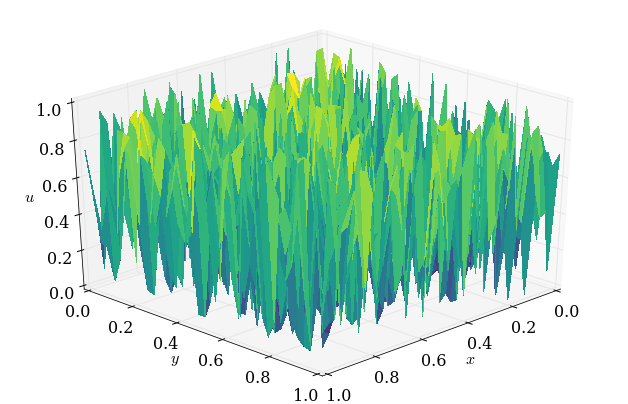

In [4]:
u0=poisson_initial(41,41)

In [5]:
@jit
def jacobi(ni,nj,n,res_target):
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    dx=1./(ni-1)
    dy=1./(nj-1)
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u_ex=numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u0=numpy.random.random((nj,ni))
    u=u0.copy()
    u[0,:]=0
    u[-1,:]=0
    u[:,0]=0
    u[:,-1]=0
    iterations=0
    dif=numpy.zeros((nj,ni))
    err=numpy.zeros((nj,ni))
    res=numpy.zeros((nj,ni))
    res_max=1e3
    
    while res_max>res_target:
        uold=u.copy()
        u[1:-1,1:-1]=1/(2*(dx**2+dy**2))*((uold[1:-1,2:]+uold[1:-1,:-2])*dy**2+\
                     (uold[2:,1:-1]+uold[:-2,1:-1])*dx**2-f[1:-1,1:-1]*dx**2*dy**2)
        #for j in range(1,nj-1):
            #for i in range(1,ni-1):
                #u[j,i]=1./(2*(dx**2+dy**2))*((uold[j,i+1]+uold[j,i-1])*dy**2+\
                       #(uold[j+1,i]+uold[j-1,i])*dx**2-f[j,i]*dx**2*dy**2)
        u[0,:]=0
        u[-1,:]=0
        u[:,0]=0
        u[:,-1]=0
        
        for j in range(1,nj-1):
            for i in range(1,ni-1):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
                   
        iterations+=1
        
    for j in range(nj):
        for i in range(ni):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
    
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
        
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

In [6]:
@jit
def SOR(ni,nj,n,res_target,omega):
    x=numpy.linspace(0,1,ni)
    y=numpy.linspace(0,1,nj)
    dx=1./(ni-1)
    dy=1./(nj-1)
    X,Y=numpy.meshgrid(x,y)
    f=-2*(2*pi*n)**2*numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u_ex=numpy.sin(2*pi*n*X)*numpy.sin(2*pi*n*Y)
    u0=numpy.random.random((nj,ni))
    u=u0.copy()
    u[0,:]=0
    u[-1,:]=0
    u[:,0]=0
    u[:,-1]=0
    dif=numpy.zeros((nj,ni))
    err=numpy.zeros((nj,ni))
    res=numpy.zeros((nj,ni))
    res_max=1e3
    iterations=0
    while res_max>res_target:
        uold=u.copy()
        for j in range(1,nj-1):
            for i in range(1,ni-1):
                u[j,i]=omega/(2*(dx**2+dy**2))*((u[j,i-1]+u[j,i+1])*dy**2+\
                       (u[j-1,i]+u[j+1,i])*dx**2-f[j,i]*dx**2*dy**2)+\
                       (1-omega)*u[j,i]
        
        
        
        u[0,:]=0
        u[-1,:]=0
        u[:,0]=0
        u[:,-1]=0
        
        for j in range(1,nj-1):
            for i in range(1,ni-1):
                res[j,i]=numpy.abs(f[j,i]-(u[j,i-1]-2*u[j,i]+u[j,i+1])/dx**2-\
                                  (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy**2)
        res_max=numpy.max(res)
        
        iterations+=1
        
    for j in range(nj):
        for i in range(ni):
            dif[j,i]=numpy.abs(u[j,i]-uold[j,i])
            err[j,i]=numpy.abs(u[j,i]-u_ex[j,i])
            
    dif_max=numpy.max(dif)
    err_max=numpy.max(err)
    
    A=numpy.array([u,x,y,dif_max,err_max,res_max,iterations])
    
    return A

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


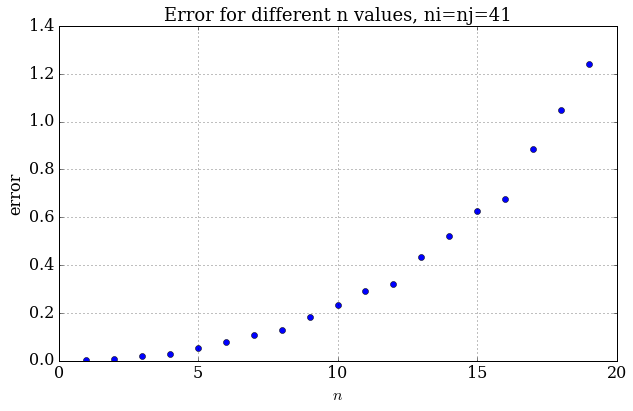

In [7]:
error40_jac=[]
for k in range(1,20):
    error40_jac.append(jacobi(41,41,k,1e-9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,19,19),error40_jac,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


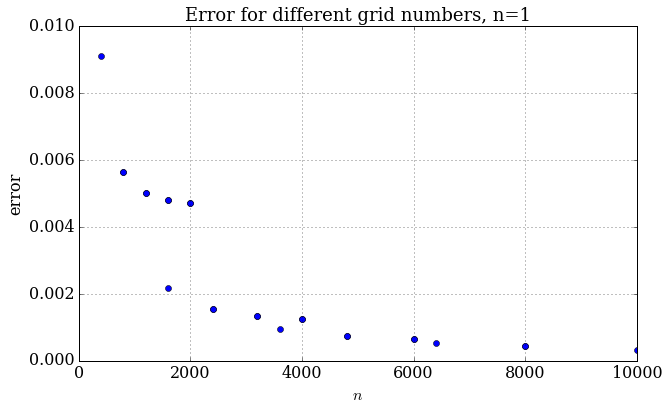

In [8]:
error_grid_jac=[]
ninj=[]
for ni in range(20,101,20):
    for nj in range(20,101,20):
        error_grid_jac.append(jacobi(ni,nj,1,1e-9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_grid_jac,'o')
pyplot.title('Error for different grid numbers, n=1',fontsize=18)
pyplot.legend()

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


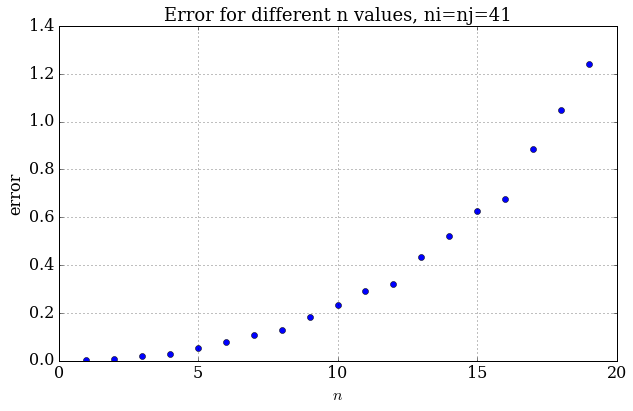

In [12]:
error40_SOR=[]
for k in range(1,20):
    error40_SOR.append(SOR(41,41,k,1e-9,1.9)[4])
    
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.linspace(1,19,19),error40_jac,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

In [15]:
error40_SOR_omega=[]
k=1.5
while k<1.96:
    error40_SOR_omega.append(SOR(41,41,1,1e-9,k)[4])
    k+=0.05
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(numpy.array(numpy.array([1.3,1.5,1.6,1.7,1.8,1.9,1.95]),error40_jac,'o')
pyplot.title('Error for different n values, ni=nj=41',fontsize=18)
pyplot.legend()

SyntaxError: invalid syntax (<ipython-input-15-ae17317983e2>, line 2)

/home/gil/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


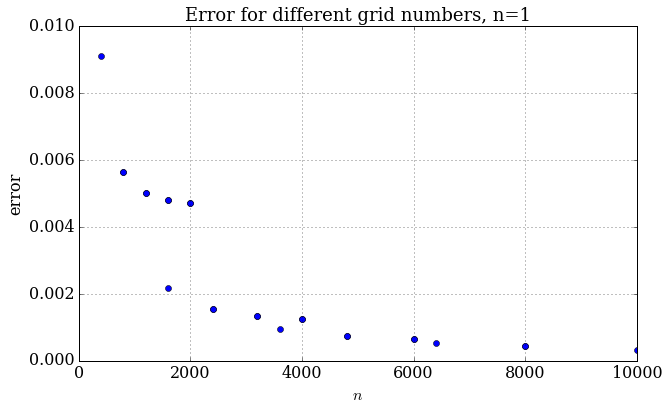

In [13]:
error_grid_SOR=[]
ninj=[]
for ni in range(20,101,20):
    for nj in range(20,101,20):
        error_grid_SOR.append(SOR(ni,nj,1,1e-9,1.9)[4])
        ninj.append(ni*nj)
        
pyplot.figure(figsize=(10,6))
pyplot.grid(True)
pyplot.xlabel('$n$')
pyplot.ylabel('error')
pyplot.plot(ninj,error_grid_jac,'o')
pyplot.title('Error for different grid numbers, n=1',fontsize=18)
pyplot.legend()

In [ ]:
u40_jac1,x40_jac1,y40_jac1,dif40_jac1,err40_jac1,res40_jac1,iterations40_jac1=jacobi(41,41,1,1e-9)
plot_3D(x40_jac1,y40_jac1,u40_jac1)
print('dif40_jacobi1={}'.format(dif40_jac1))
print('err40_jacobi1={}'.format(err40_jac1))
print('res40_jacobi1={}'.format(res40_jac1))
print('iterations40_jacobi1={}'.format(iterations40_jac1))

In [ ]:
u_jac2,x_jac2,y_jac2,dif_jac2,err_jac2,res_jac2,iterations_jac2=jacobi(41,41,2,1e-9)
plot_3D(x_jac2,y_jac2,u_jac2)
print('dif_jacobi2={}'.format(dif_jac2))
print('err_jacobi2={}'.format(err_jac2))
print('res_jacobi2={}'.format(res_jac2))
print('iterations_jacobi2={}'.format(iterations_jac2))

In [ ]:
u_jac3,x_jac3,y_jac3,dif_jac3,err_jac3,res_jac3,iterations_jac3=jacobi(41,41,3,1e-9)
plot_3D(x_jac3,y_jac3,u_jac3)
print('dif_jacobi3={}'.format(dif_jac3))
print('err_jacobi3={}'.format(err_jac3))
print('res_jacobi3={}'.format(res_jac3))
print('iterations_jacobi3={}'.format(iterations_jac3))

In [ ]:
u_jac4,x_jac4,y_jac4,dif_jac4,err_jac4,res_jac4,iterations_jac4=jacobi(41,41,4,1e-9)
print('dif_jacobi4={}'.format(dif_jac4))
print('err_jacobi4={}'.format(err_jac4))
print('res_jacobi4={}'.format(res_jac4))
print('iterations_jacobi4={}'.format(iterations_jac4))

In [ ]:
u80_jac1,x80_jac1,y80_jac1,dif80_jac1,err80_jac1,res80_jac1,iterations80_jac1=jacobi(81,81,1,1e-9)
plot_3D(x80_jac1,y80_jac1,u80_jac1)
print('dif80_jacobi1={}'.format(dif80_jac1))
print('err80_jacobi1={}'.format(err80_jac1))
print('res80_jacobi1={}'.format(res80_jac1))
print('iterations80_jacobi1={}'.format(iterations80_jac1))

In [ ]:
u120_jac1,x120_jac1,y120_jac1,dif120_jac1,err120_jac1,res120_jac1,iterations120_jac1=jacobi(121,121,1,1e-9)
print('dif120_jacobi1={}'.format(dif120_jac1))
print('err120_jacobi1={}'.format(err120_jac1))
print('res120_jacobi1={}'.format(res120_jac1))
print('iterations120_jacobi1={}'.format(iterations120_jac1))

In [ ]:
u160_jac1,x160_jac1,y160_jac1,dif160_jac1,err160_jac1,res160_jac1,iterations160_jac1=jacobi(161,161,1,1e-9)
print('dif160_jacobi1={}'.format(dif160_jac1))
print('err160_jacobi1={}'.format(err160_jac1))
print('res160_jacobi1={}'.format(res160_jac1))
print('iterations160_jacobi1={}'.format(iterations160_jac1))

In [ ]:
u_SOR1,x_SOR1,y_SOR1,dif_SOR1,err_SOR1,res_SOR1,iterations_SOR1=SOR(41,41,1,1e-9,1.5)
plot_3D(x_SOR1,y_SOR1,u_SOR1)
print('dif_SOR1={}'.format(dif_SOR1))
print('err_SOR1={}'.format(err_SOR1))
print('res_SOR1={}'.format(res_SOR1))
print('iterations_SOR1={}'.format(iterations_SOR1))

In [ ]:
u_SOR2,x_SOR2,y_SOR2,dif_SOR2,err_SOR2,res_SOR2,iterations_SOR2=SOR(41,41,2,1e-9,1.5)
plot_3D(x_SOR2,y_SOR2,u_SOR2)
print('dif_SOR2={}'.format(dif_SOR2))
print('err_SOR2={}'.format(err_SOR2))
print('res_SOR2={}'.format(res_SOR2))
print('iterations_SOR2={}'.format(iterations_SOR2))

In [ ]:
u_SOR3,x_SOR3,y_SOR3,dif_SOR3,err_SOR3,res_SOR3,iterations_SOR3=SOR(41,41,3,1e-9,1.5)
plot_3D(x_SOR3,y_SOR3,u_SOR3)
print('dif_SOR3={}'.format(dif_SOR3))
print('err_SOR3={}'.format(err_SOR3))
print('res_SOR3={}'.format(res_SOR3))
print('iterations_SOR3={}'.format(iterations_SOR3))

In [ ]:
u_SOR4,x_SOR4,y_SOR4,dif_SOR4,err_SOR4,res_SOR4,iterations_SOR4=SOR(41,41,4,1e-9,1.5)
print('dif_SOR4={}'.format(dif_SOR4))
print('err_SOR4={}'.format(err_SOR4))
print('res_SOR4}'.format(res_SOR4))
print('iterations_SOR4={}'.format(iterations_SOR4))